# Netflix Content Clustering

Netflix's library is vast and diverse. The goal of this project is to uncover hidden patterns or clusters in the titles available on the platform to:
- Guide content acquisition strategies
- Understand genre groupings, release timelines, and content types
- Deliver business recommendations based on cluster characteristics


Import Libraries & Load Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import plotly.express as px
import warnings
warnings.filterwarnings("ignore")




In [3]:
df = pd.read_csv("/content/netflix_ML.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


Understanding the Dataset

In [4]:
df.info()
df.describe(include='all')
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


,0
show_id,0
type,0
title,0
director,2389
cast,718
country,507
date_added,10
release_year,0
rating,7
duration,0


We start by understanding key metadata: title, genre, type, cast, country, release year, duration, and description. Missing data is particularly present in `cast` and `country`, requiring imputation or exclusion.


Data Cleaning & Handling Missing Values

In [5]:
# Drop columns with too much missing data
df.drop(columns=["director"], inplace=True)

# Fill nulls
df['cast'].fillna("Unknown", inplace=True)
df['country'].fillna(df['country'].mode()[0], inplace=True)
df['rating'].fillna("Unknown", inplace=True)
df['duration'].fillna("Unknown", inplace=True)

df.dropna(inplace=True)


# Exploratory Data Analysis (EDA)
Distribution of Content Types

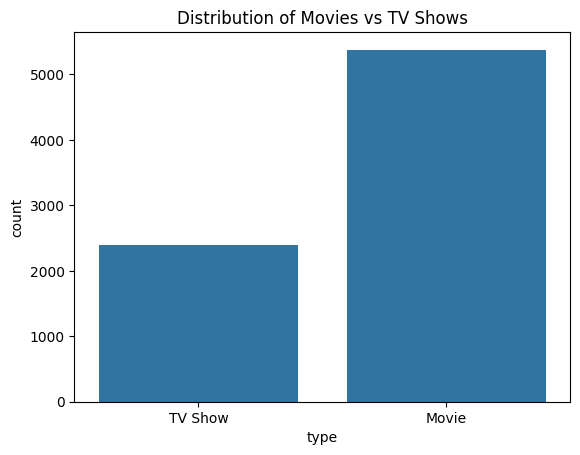

In [6]:
sns.countplot(data=df, x='type')
plt.title("Distribution of Movies vs TV Shows")
plt.show()


Content Over Time

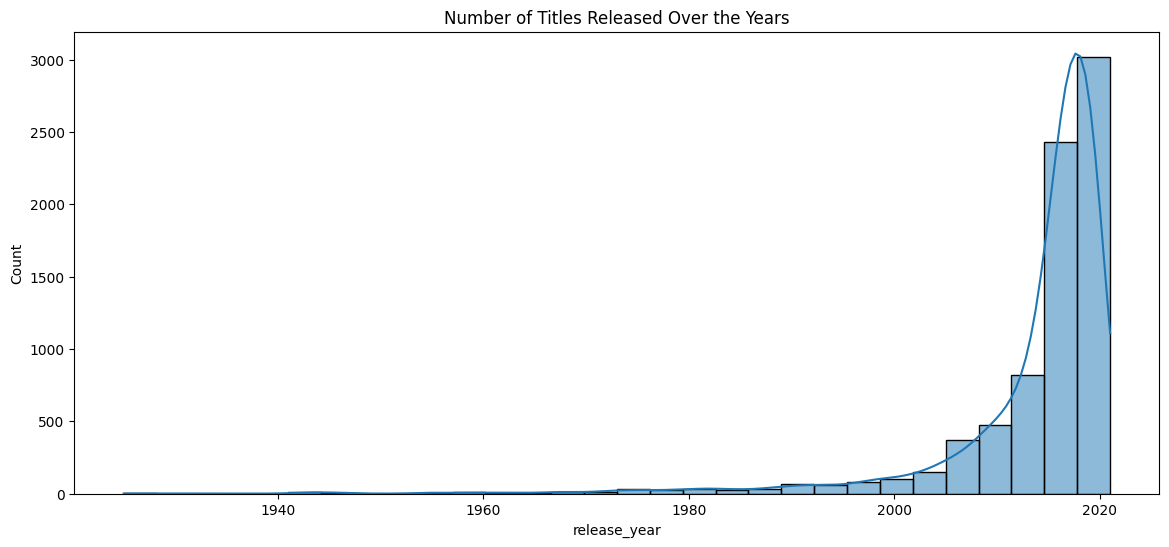

In [7]:
plt.figure(figsize=(14,6))
sns.histplot(df['release_year'], bins=30, kde=True)
plt.title("Number of Titles Released Over the Years")
plt.show()


Top Countries by Production

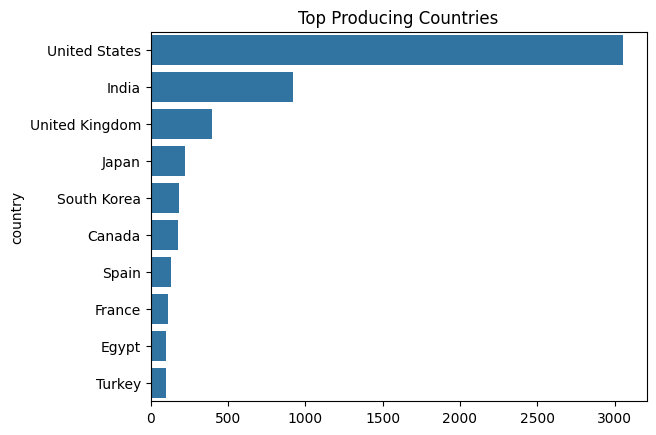

In [8]:
top_countries = df['country'].value_counts().head(10)
sns.barplot(y=top_countries.index, x=top_countries.values)
plt.title("Top Producing Countries")
plt.show()


Feature Engineering for Clustering

In [9]:
# Combine genre and description
df['text_features'] = df['listed_in'] + ' ' + df['description']

# TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf.fit_transform(df['text_features'])

# Reduce dimensionality
pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_matrix.toarray())


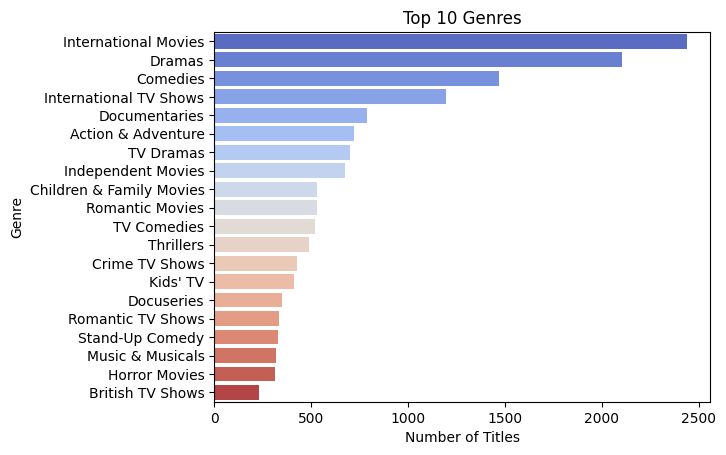

In [10]:
from collections import Counter

genre_list = df['listed_in'].dropna().str.split(', ')
genre_flat = [genre for sublist in genre_list for genre in sublist]
top_genres = Counter(genre_flat).most_common(20)

genres, counts = zip(*top_genres)
sns.barplot(x=counts, y=genres, palette='coolwarm')
plt.title('Top 10 Genres')
plt.xlabel('Number of Titles')
plt.ylabel('Genre')
plt.show()


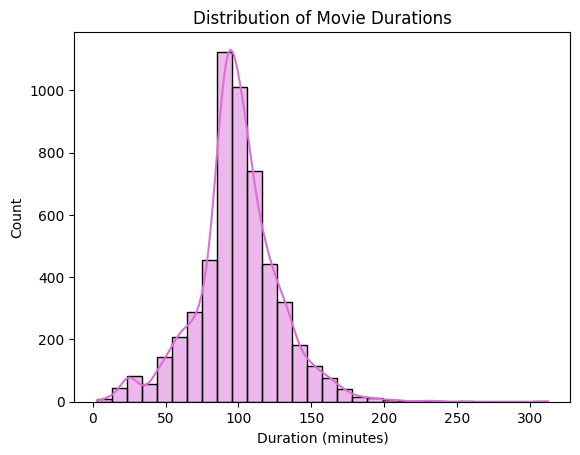

In [11]:
movie_df = df[df['type'] == 'Movie'].copy()
movie_df['duration_mins'] = movie_df['duration'].str.extract(r'(\d+)').astype(float)

sns.histplot(movie_df['duration_mins'].dropna(), bins=30, kde=True, color='orchid')
plt.title('Distribution of Movie Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.show()


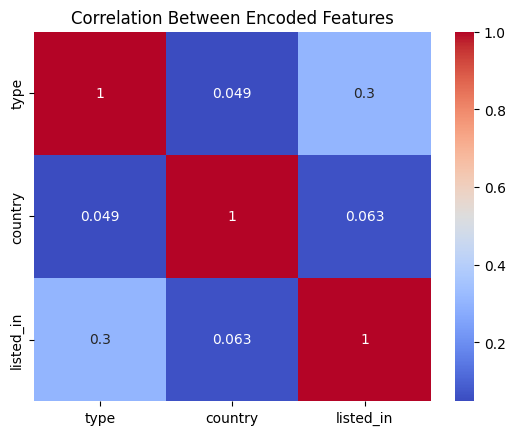

In [12]:
from sklearn.preprocessing import LabelEncoder

encoded_df = df[['type', 'country', 'listed_in']].dropna().copy()
for col in encoded_df.columns:
    encoded_df[col] = LabelEncoder().fit_transform(encoded_df[col])

sns.heatmap(encoded_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Between Encoded Features")
plt.show()


# Clustering Models

**KMeans**

In [13]:
from sklearn.decomposition import PCA

# Reduce dimensions before clustering
pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_matrix.toarray())  # or your chosen features

# Clustering with KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(reduced)


In [14]:
# Create a DataFrame for visualization
cluster_df = pd.DataFrame(reduced, columns=['PCA1', 'PCA2'])
cluster_df['Cluster'] = kmeans_labels
cluster_df['Title'] = df['title']
cluster_df['Type'] = df['type']
cluster_df['Genre'] = df['listed_in']
cluster_df['Country'] = df['country']

# Plot with Plotly
fig = px.scatter(
    cluster_df, x='PCA1', y='PCA2',
    color='Cluster',
    hover_data=['Title', 'Genre', 'Country', 'Type'],
    title="Netflix Titles Clustered by Content Features (KMeans)",
    color_continuous_scale=px.colors.qualitative.Set1
)
fig.update_layout(legend_title_text='Cluster ID')
fig.show()

**DBSCAN**

In [15]:
import plotly.express as px

from sklearn.cluster import DBSCAN

# Run DBSCAN (you can tune eps and min_samples based on your data)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(reduced)  # assuming 'reduced' is your PCA output

dbscan_df = pd.DataFrame(reduced, columns=['PCA1', 'PCA2'])
dbscan_df['Cluster'] = dbscan_labels
dbscan_df['Title'] = df['title']
dbscan_df['Type'] = df['type']
dbscan_df['Genre'] = df['listed_in']
dbscan_df['Country'] = df['country']

fig = px.scatter(
    dbscan_df, x='PCA1', y='PCA2',
    color='Cluster',
    hover_data=['Title', 'Genre', 'Country', 'Type'],
    title="Netflix Titles Clustered by Content Features (DBSCAN)",
    color_continuous_scale=px.colors.qualitative.Set1
)
fig.update_layout(legend_title_text='Cluster ID')
fig.show()


In [16]:
from sklearn.cluster import AgglomerativeClustering

# Perform Agglomerative Hierarchical Clustering
hclust = AgglomerativeClustering(n_clusters=5)  # You can tune n_clusters
hierarchical_labels = hclust.fit_predict(reduced)  # 'reduced' is your PCA output


In [17]:
import plotly.express as px

hclust_df = pd.DataFrame(reduced, columns=['PCA1', 'PCA2'])
hclust_df['Cluster'] = hierarchical_labels
hclust_df['Title'] = df['title']
hclust_df['Type'] = df['type']
hclust_df['Genre'] = df['listed_in']
hclust_df['Country'] = df['country']

fig = px.scatter(
    hclust_df, x='PCA1', y='PCA2',
    color='Cluster',
    hover_data=['Title', 'Genre', 'Country', 'Type'],
    title="Netflix Titles Clustered by Content Features (Hierarchical Clustering)",
    color_continuous_scale=px.colors.qualitative.Set1
)
fig.update_layout(legend_title_text='Cluster ID')
fig.show()


# INSIGHTS FROM THIS ANALYSIS


The insights here empower stakeholders to:
- Identify underrepresented content categories
- Strategize market-specific content expansion
- Improve UX through content recommendation grouping
